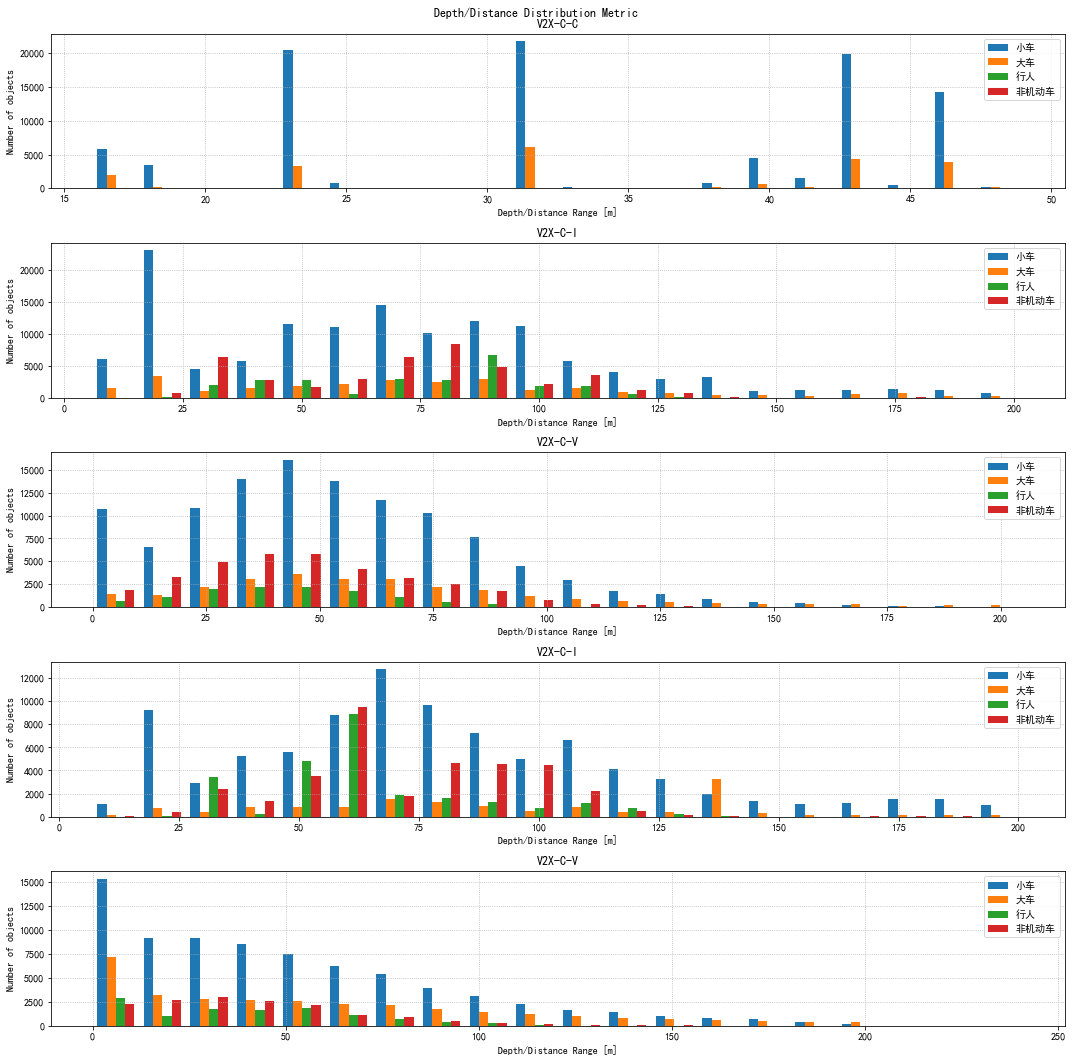

In [31]:
import json
import math
import warnings
import numpy as np
import os
from matplotlib import pyplot as plt
from mplfonts.bin.cli import init as init_fonts


def print_json(data):
    # json 是由多个对象组成的 array, 可以用循环+pop迭代出每个对象
    while data.__len__() != 0:
        """
        {
          "type": "Cyclist",
          "occluded_state": "0",
          "truncated_state": "1",
          "alpha": "0",
          "2d_box": {
            "xmin": "1528.72644",
            "ymin": "289.33963",
            "xmax": "1597.9943839999999",
            "ymax": "365.06311"
          },
          "3d_dimensions": { "h": "1.648045", "w": "0.761443", "l": "1.367346" },
          "3d_location": { "x": "53.078157", "y": "-19.375766", "z": "-0.835138" },
          "rotation": "1.6607585677685388"
        }
        """
        pop = data.pop()

        print(f'type: {pop["type"]}\
              occluded_state: {pop["occluded_state"]}\
              truncated_state: {pop["truncated_state"]}\
              alpha: {pop["alpha"]}\
              2d_box: {pop["2d_box"]}\
              3d_dimensions: {pop["3d_dimensions"]}\
              3d_location: {pop["3d_location"]}\
              rotation: {pop["rotation"]}\
            '                          )


def counter(data):
    hashmap = {}
    while data.__len__() != 0:
        value = data.pop()["type"]
        if hashmap.get(value) is None:
            hashmap[value] = 0
        hashmap[value] += 1
    return hashmap


def depth_distribution_deprecated(data):
    # 废弃的, 手动划分距离区域, 后来发现 plt.hist() 可以直接划分
    warnings.warn("some_old_function is deprecated", DeprecationWarning)

    # 0 20 40 60 80 100 120 140(>=140的所有)
    depth = np.zeros((4, 8))

    while data.__len__() != 0:
        pop = data.pop()

        _type = pop["type"]
        index_1 = -1
        if _type in ["Car"]:
            index_1 = 0
        elif _type in ["Van", "Truck", "Bus"]:
            index_1 = 1
        elif _type in ["Pedestrian"]:
            index_1 = 2
        elif _type in ["Cyclist", "Motorcyclist", "Barrow", "Tricyclist"]:
            index_1 = 3

        # 不属于四大类, 比如 Trafficcone
        if index_1 == -1:
            continue

        _3d_location = pop["3d_location"]
        # 化整加快计算
        x = round(float(_3d_location["x"]))
        y = round(float(_3d_location["y"]))
        distance = math.sqrt(x * x + y * y)

        # 把 >= 140 的所有值囊括
        index_2 = distance // 20 if distance // 20 <= 7 else 7

        depth[index_1][int(index_2)] += 1

    # 上/下 分别为 距离/个数
    # 0 20 40 60 80 100 120 140(>=140的所有)
    #              |
    #              v
    # [[3. 6. 4. 5. 9. 6. 3. 3.]    小车
    #  [0. 0. 0. 0. 0. 2. 0. 0.]    大车
    #  [0. 0. 3. 0. 0. 0. 0. 0.]    行人
    #  [0. 0. 4. 3. 2. 0. 0. 0.]]   非机动车
    return depth


def depth_distribution(file, pre_depth_category, division):
    # list append 效率高, 用来存储距离信息
    depth_category = pre_depth_category if pre_depth_category else [
        list() for _ in range(4)
    ]

    while file.__len__() != 0:
        pop = file.pop()

        _3d_location = pop["3d_location"]
        # 化整加快计算
        x = round(float(_3d_location["x"]) / division)
        y = round(float(_3d_location["y"]) / division)
        distance = round(math.sqrt(x * x + y * y))

        _type = pop["type"].lower()
        if _type in ["car"]:
            depth_category[0].append(distance)
        elif _type in ["van", "truck", "bus"]:
            depth_category[1].append(distance)
        elif _type in ["pedestrian"]:
            depth_category[2].append(distance)
        elif _type in ["cyclist", "motorcyclist", "barrow", "tricyclist"]:
            depth_category[3].append(distance)

        # 不属于四大类, 比如 Trafficcone 不用管

    return depth_category


def single_data():
    with open(
            "../../../link2paths/DAIR-V2X/single-infrastructure-side/label/camera/000000.json",
            'r') as f:
        data = json.load(f)

        # [{'type': 'Cyclist', 'occluded_state': '0', 'truncated_state': '1', 'alpha': '0', '2d_box': {'xmin': '1528.72644', 'ymin': '289.33963', 'xmax': '1597.9943839999999', 'ymax': '365.06311'}, '3d_dimensions': {'h': '1.648045', 'w': '0.761443', 'l': '1.367346'}, '3d_location': {'x': '53.078157', 'y': '-19
        # print(data)

        # print_json(data)

        # {'Car': 39, 'Trafficcone': 16, 'Motorcyclist': 5, 'Cyclist': 4, 'Van': 1, 'Pedestrian': 3, 'Bus': 1}
        # print(counter(data))
        f.close()

        # [[110, 80, 183, 60, 86, 78, 199, 38, 51, 15, 25, 117, 88, 80, 115, 87, 123, 99, 97, 24, 38, 20, 47, 61, 113, 52, 89, 127, 134, 18, 68, 97, 48, 108, 104, 187, 76, 15, 39], [116, 102], [51, 50, 54], [61, 54, 61, 97, 90, 78, 51, 50, 56]]
        #
        # out = depth_distribution_deprecated(data)
        out = depth_distribution(data, None)

    return out


def dataset(datasets):
    pre_depth_category = [None for _ in range(len(datasets))]

    for i in range(len(datasets)):
        files = os.listdir(datasets[i])

        # 判断是不是世界坐标系, 仅用第一个文件就行 (除非是空的)
        with open(datasets[i] + "/" + files[0], 'r') as f:
            division = 100 if float(
                json.load(f).pop()['3d_location']['x']) > 300 else 1
            f.close()

        for file in files:
            with open(datasets[i] + "/" + file, 'r') as f:
                pre_depth_category[i] = depth_distribution(
                    json.load(f), pre_depth_category[i], division)
                f.close()

    return pre_depth_category


def draw_depth_distribution(depth_category,
                            title='',
                            xlabel='',
                            ylabel='',
                            bins=20,
                            label=None,
                            sub_title=None):
    #用来正常显示中文标签
    plt.rcParams['font.sans-serif'] = ['SimHei']
    #用来正常显示负号
    plt.rcParams['axes.unicode_minus'] = False

    # 可视化
    plt.figure(figsize=(15, 15))
    plt.suptitle(title)

    for i in range(len(depth_category)):
        plt.subplot(len(depth_category), 1, i + 1)
        plt.grid(linestyle=':')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.hist(depth_category[i], bins=bins, label=label)
        plt.legend(loc='upper right')
        plt.title(sub_title[i])
        # 调整大小和间距
        plt.tight_layout()

    plt.show()


if __name__ == '__main__':
    # sum = single_data()

    # camera 与 virtuallidar 相同, 只取了一个
    datasets = [
        [
            '../../../link2paths/DAIR-V2X/cooperative-vehicle-infrastructure/cooperative/label_world',
            '../../../link2paths/DAIR-V2X/cooperative-vehicle-infrastructure/infrastructure-side/label/camera',
            '../../../link2paths/DAIR-V2X/cooperative-vehicle-infrastructure/vehicle-side/label/camera',
            '../../../link2paths/DAIR-V2X/single-infrastructure-side/label/camera',
            '../../../link2paths/DAIR-V2X/single-vehicle-side/label/camera',
        ],
        [
            'V2X-C-C',
            'V2X-C-I',
            'V2X-C-V',
            'V2X-C-I',
            'V2X-C-V',
        ],
    ]

    draw_depth_distribution(dataset(datasets[0]),
                            title='Depth/Distance Distribution Metric',
                            xlabel='Depth/Distance Range [m]',
                            ylabel='Number of objects',
                            label=["小车", "大车", "行人", "非机动车"],
                            sub_title=datasets[1])
